# Extracting Social Determinants of Health from Clinical Notes with Groq API's Json Mode

Since the dawn of the Electronic Health Record, deriving meaningful insights about the social determinants of health of a patient population has been the holy grail of healthcare analytics. While discrete clinical data (vitals, lab results, diagnoses, etc) is well understood, social determinants - things like financial insecurity, which can determine patient outcomes and barriers to care as much as the patient's clinical chart - are often hidden in clinical notes and unused by analytics departments. While some providers code social determinants using [Z codes](https://www.cms.gov/files/document/zcodes-infographic.pdf), these are often too inconsistently documented and many risk models seeking to add a social determinant score will simply default to using zip code as a crude proxy. With the emergence of Large Language Models, AI has the ability to extract and structure meaningful insights from free-text clinical notes at scale, enabling more effective patient outreach, better risk modeling and a more robust understanding of a patient population as a whole.

This notebook shows how we can use Groq API's new [JSON mode](https://console.groq.com/docs/text-chat#json-mode-object-object) feature to extract social determinants of health from fake clinical notes, structure them into a neat table that can be used for analytics and load them into [BigQuery](https://cloud.google.com/bigquery). With JSON mode, we can return structured data from the chat completion in a pre-defined format, making it a great feature for structuring unstructrued data. We will read in each note, ask the LLM to determine if certain social determinant features are met, output structured data and load it into a database to be incorporated with the rest of our clinical data marts.

### Setup

In [1]:
# Import packages
from groq import Groq
import pandas as pd
import os
from IPython.display import Markdown
import json
from google.cloud import bigquery
import matplotlib.pyplot as plt

This code block loads in clinical notes from [our repository](https://github.com/groq/groq-api-cookbook/json-mode-social-determinants-of-health/clinical_notes) and displays the first note. As you can see, this hypothetical patient has quite a few notable social determinants of health that contribute to their health outcomes and treatment:

In [2]:
# Define the directory path
folder_path = 'clinical_notes/'

# List all files in the directory
file_list = os.listdir(folder_path)
text_files = sorted([file for file in file_list if file.endswith('.txt')])

with open(os.path.join(folder_path, text_files[0]), 'r') as file:
    clinical_note = file.read()

display(Markdown(clinical_note))

**Date:** March 28, 2024

**Patient:** David Smith, 42 years old

**MRN:** 00456321

**Chief Complaint:** "I've been feeling really tired lately, more than usual."

**History of Present Illness:** The patient is a 42-year-old who presents with a 3-week history of increased fatigue, decreased energy, and occasional headaches. The patient reports struggling with sleep due to stress from work and personal life. The patient is currently working two part-time jobs but still finds it hard to make ends meet, indicating financial stress. They express concern over the cost of medications and healthcare visits.

**Past Medical History:** Type 2 Diabetes Mellitus, Hypertension

**Social History:**
The patient juggles two jobs to make ends meet, one at a local retail store and another in a fast-food chain, neither offering full-time hours or benefits. Despite the long hours, the patient mentions financial difficulties, especially with covering rent and providing. They share an apartment with three others in an area described as 'not the safest,' due to recent break-ins and a noticeable police presence. Meals are often missed or minimal, as the patient tries to stretch their budget, sometimes seeking help from local food banks when things get particularly tight.

Educationally, the patient completed high school but hasn't pursued further studies, citing lack of funds and the immediate need to support their family after graduation. They rely on buses and trains for transportation, which complicates timely access to healthcare, often causing delays or missed appointments. Socially, the patient admits to feeling isolated, with most of their family living out of state after their divorce and a personal life that has been 'on hold' due to work and financial pressures. They have a basic health insurance plan with high co-payments, which has led to skipping some recommended medical tests and treatments.

**Review of Systems:** Denies chest pain, shortness of breath, or fever. Reports occasional headaches.

**Physical Examination:**
- General: Appears tired but is alert and oriented.
- Vitals: BP 142/89, HR 78, Temp 98.6°F, Resp 16/min

**Assessment/Plan:**
- Continue to monitor blood pressure and diabetes control.
- Discuss affordable medication options with a pharmacist.
- Refer to a social worker to address food security, housing concerns, and access to healthcare services.
- Encourage the patient to engage with community support groups for social support.
- Schedule a follow-up appointment in 4 weeks or sooner if symptoms worsen.

**Comments:** The patient's health concerns are compounded by socioeconomic factors, including employment status, housing stability, food security, and access to healthcare. Addressing these social determinants of health is crucial for improving the patient's overall well-being.


### Define System and User Prompts

Crafting clear and effective prompts is crucial for generating valid LLM responses. In our case, we've defined the exact JSON schema for our social determinants of health table we expect the LLM to output and are including it in the system prompt. Then in the user prompt, we will include the entire clinical note in the context window.

In [3]:
# Define system prompt (note: system prompt must contain "JSON" in it)
system_prompt = '''
You are a medical coding API specializing in social determinants of health that responds in JSON.
Your job is to extract structured SDOH data from an unstructured clinical note and output the structured data in JSON.
The JSON schema should include:
  {
    "employment_status": "string (categorical: 'Unemployed', 'Part-time', 'Full-time', 'Retired')",
    "financial_stress": "boolean (TRUE if the patient mentions financial difficulties)",
    "housing_insecurity": "boolean (TRUE if the patient does not live in stable housing conditions)",
    "neighborhood_unsafety": "boolean (TRUE if the patient expresses concerns about safety)",
    "food_insecurity": "boolean (TRUE if the patient does not have reliable access to sufficient food)",
    "education_level": "string (categorical: 'None', 'High School', 'College', 'Graduate')",
    "transportation_inaccessibility": "boolean (TRUE if the patient does not have reliable transportation to healthcare appointments)",
    "social_isolation": "boolean (TRUE if the patient mentions feeling isolated or having a lack of social support)",
    "health_insurance_inadequacy": (boolean: TRUE if the patient's health insurance is insufficient),
    "skipped_care_due_to_cost": "boolean (TRUE if the patient mentions skipping medical tests or treatments due to cost)",
    "marital_status": "string (categorical: 'Single', 'Married', 'Divorced', 'Widowed')",
    "language_barrier": "boolean (TRUE if the patient has language barriers to healthcare access)"
  }
'''

In [4]:
# Define user prompt template
user_prompt_template = '''
Use information from following clinical note to construct the proper JSON output:

{clinical_note}
'''

### Executing Chat Completions with JSON Mode 

Now that we have our notes and our prompts, let's try running a Groq chat completion with JSON mode enabled on the first clinical note to see if the ```mixtral-8x7b-32768``` model can correctly identify this patient's social determinants. Note that you will need a Groq API Key to proceed and can create an account [here](https://console.groq.com/) to generate one for free:

In [5]:
# Establish client with GROQ_API_KEY environment variable
client = Groq(api_key=os.getenv('GROQ_API_KEY'))
model = "mixtral-8x7b-32768"

# Create chat completion object with JSON response format
chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt_template.format(clinical_note=clinical_note),
        }
    ],
    model = model,
    response_format = {"type": "json_object"} # Add this response format to configure JSON mode
)

social_determinants_json_string = chat_completion.choices[0].message.content
print(social_determinants_json_string)

{
  "employment_status": "Part-time",
  "financial_stress": true,
  "housing_insecurity": true,
  "neighborhood_unsafety": true,
  "food_insecurity": true,
  "education_level": "High School",
  "transportation_inaccessibility": true,
  "social_isolation": true,
  "health_insurance_inadequacy": true,
  "skipped_care_due_to_cost": true,
  "marital_status": "Divorced",
  "language_barrier": false
}


Looks good! The patient does in fact work part time, is divorced and has expressed concerns pertaining their financial, housing and transportation situations, food insecurity, social isolation and healthcare costs. They do not have a language barrier.

Now, let's wrap this in a function and apply it to the rest of our clinical notes:

In [6]:
def extract_sdoh_json(system_prompt,user_prompt,model):
    
    # Establish client with GROQ_API_KEY environment variable
    client = Groq(api_key=os.getenv('GROQ_API_KEY'))
    
    # Create chat completion object with JSON response format
    chat_completion = client.chat.completions.create(
        messages = [
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt_template.format(clinical_note=clinical_note),
            }
        ],
        model = model,
        response_format = {"type": "json_object"} # Add this response format to configure JSON mode
    )
    
    social_determinants_json_string = chat_completion.choices[0].message.content

    # Return json object of the chat output
    return json.loads(social_determinants_json_string)

In [7]:
# Total latency: 11.91s

model = "mixtral-8x7b-32768"

patients_data = []
# Loop through each patient clinical note, extract structured SDOH and compile a list of JSON objects
for file_name in text_files:
    with open(os.path.join(folder_path, file_name), 'r') as file:
        clinical_note = file.read()
        user_prompt = user_prompt_template.format(clinical_note=clinical_note)
        social_determinants_json = extract_sdoh_json(system_prompt,user_prompt,model)
        social_determinants_json['mrn'] = file_name[:-4] # The name of the file is the patient's MRN 
        patients_data.append(social_determinants_json)

# Flatten the results into a dataframe
flattened_data = []
for patient in patients_data:
    flattened_data.append({'mrn': patient['mrn'],
                           'employment_status': patient['employment_status'],
                           'financial_stress': patient['financial_stress'],
                           'housing_insecurity': patient['housing_insecurity'],
                           'neighborhood_unsafety': patient['neighborhood_unsafety'],
                           'food_insecurity': patient['food_insecurity'],
                           'education_level': patient['education_level'],
                           'transportation_inaccessibility': patient['transportation_inaccessibility'],
                           'social_isolation': patient['social_isolation'],
                           'health_insurance_inadequacy': patient['health_insurance_inadequacy'],
                           'skipped_care_due_to_cost': patient['skipped_care_due_to_cost'],
                           'marital_status': patient['marital_status'],
                           'language_barrier': patient['language_barrier']})


sdoh_df = pd.DataFrame(flattened_data)

sdoh_df

,mrn,employment_status,financial_stress,housing_insecurity,neighborhood_unsafety,food_insecurity,education_level,transportation_inaccessibility,social_isolation,health_insurance_inadequacy,skipped_care_due_to_cost,marital_status,language_barrier
0,00456321,Part-time,True,True,True,True,High School,True,True,True,True,Divorced,False
1,00567289,Full-time,True,False,False,False,College,False,True,False,False,Single,False
2,00678934,Retired,False,False,False,False,College,True,True,False,False,Widowed,False
3,00785642,Full-time,False,False,False,False,College,False,False,False,False,Married,False
4,00893247,Unemployed,True,True,True,True,None,False,True,True,True,Single,True


Nice! In just under 12 seconds we've parsed through five clinical notes, extracted discrete features and structured them into a neat table. That low latency is important for scaling up, and is why Groq's best-in-class speed makes it an ideal provider for this type of task - in a healthcare network with many providers, it would allow us to process clinical notes for 1500 patients in an hour.

### Analyzing Structured Data

Now that our Social Determinants of Health are stored in a neat, structured format, we can analyze them much easier than when they're trapped in unstructured clinical notes. Here is a bar plot showing the percent of the patient population impacted by each social determinant - but with more data we could do far more advanced analyses such as showing which determinants are most correlated with each other, or which ones are most predictive of various chronic conditions or negative health outcomes:

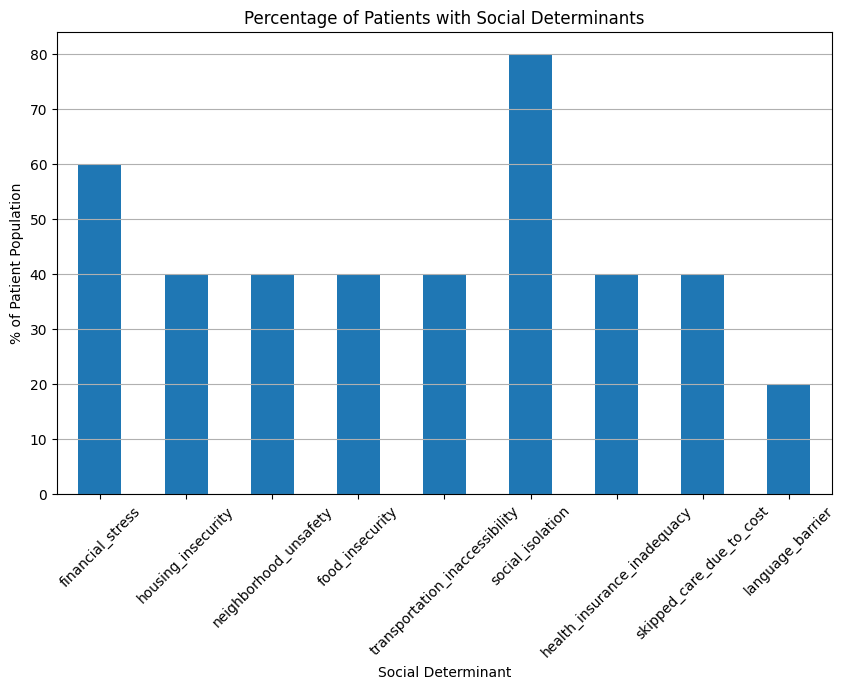

In [8]:
# Limit dataframe to boolean fields
df = sdoh_df[['financial_stress','housing_insecurity','neighborhood_unsafety','food_insecurity','transportation_inaccessibility','social_isolation','health_insurance_inadequacy','skipped_care_due_to_cost','language_barrier']]

# Calculate the percentage of 'True' values for each boolean field
percentages = df.mean() * 100  # df.mean() computes the mean for each column, 'True' is treated as 1, 'False' as 0

# Plotting
plt.figure(figsize=(10, 6))
percentages.plot(kind='bar')
plt.title('Percentage of Patients with Social Determinants')
plt.ylabel('% of Patient Population')
plt.xlabel('Social Determinant')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()


### Loading to a Database

Finally, we will use [SQLAlchemy](https://pypi.org/project/SQLAlchemy/) to load the results to our database - in this case, a BigQuery dataset called ```clinical```. In a real production environment, we could use a tool like [Airflow](https://airflow.apache.org/) to orchestrate the scheduling of this script and process any new notes from recent appointments. 

In [9]:
# Append results to a pre-existing BigQuery table
client = bigquery.Client()
sdoh_df.to_gbq('clinical.social_determinants',client.project,credentials=client._credentials,if_exists='append')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]


### Conclusion

In this notebook, we've used Groq API's JSON mode to extract social determinants of health from and structure them in a relational table, then loaded the results into BigQuery where they can be combined and analyzed with the rest of our patient data. With our social determinants of health now structured in our clinical data warehouse, our analytics team can use it in countless ways by delivering much-needed SDOH insights and enhancing risk models. This allows the clinical practice to not just identify high-risk patients in their population, but to implement more targeted interventions by better understanding their barriers to care.

More broadly, we've shown how to use Groq to build an LLM-infused data pipeline, one that transforms unstructured text data into structured, relational data that can reside in a warehouse. And with Groq's low latency, the ability to process more files per minute makes for a more efficient pipeline.